# Capstone Project: Deepfake Detection in Images using Deep learning

# Problem Statement

DeepFake is composed from Deep Learning and Fake and means taking one person from an image or video and replacing with someone else likeness using technology such as Deep Artificial Neural Networks. Large companies like Google invest very much in fighting the DeepFake, this including release of large datasets to help training models to counter this threat.The phenomen invades rapidly the film industry and threatens to compromise news agencies. Large digital companies, including content providers and social platforms are in the frontrun of fighting Deep Fakes.We will work on detecting faces that were forged and we will work on developing a model to detect images.

## About the Dataset

This dataset contains faces extracted from deepfake-detection-challenge. All images were of size 224x224. 

Due to memory issue we will only use a sample of the entire dataset for prediction.

## Importing Required libraries

In [1]:
!pip install -U --upgrade tensorflow

     |████████████████████████████████| 458.3MB 28kB/s s eta 0:00:01     |██████████████▏                 | 202.9MB 49.3MB/s eta 0:00:06
     |████████████████████████████████| 5.6MB 27.9MB/s eta 0:00:01
     |████████████████████████████████| 4.0MB 39.6MB/s eta 0:00:01
     |████████████████████████████████| 4.6MB 46.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 4.6MB/s  eta 0:00:01
     |████████████████████████████████| 61kB 5.0MB/s  eta 0:00:01
     |████████████████████████████████| 133kB 33.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 6.6MB/s  eta 0:00:01
     |████████████████████████████████| 471kB 28.5MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 39.6MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 41.5MB/s eta 0:00:01
     |████████████████████████████████| 4.9MB 45.7MB/s eta 0:00:01
     |████████████████████████████████| 788kB 42.7MB/s eta 0:00:01
  Created wheel for wrapt: filename=wrapt-1.12.1-cp36-cp36m-l

In [2]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [3]:
tf.test.is_gpu_available()

False

In [4]:
tf.__version__

'2.6.2'

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [6]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [7]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [8]:
meta.shape

(95634, 5)

In [9]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [10]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

Instead of using 95k images we will only use 16000 images due to memory issue.

In [11]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [12]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [13]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

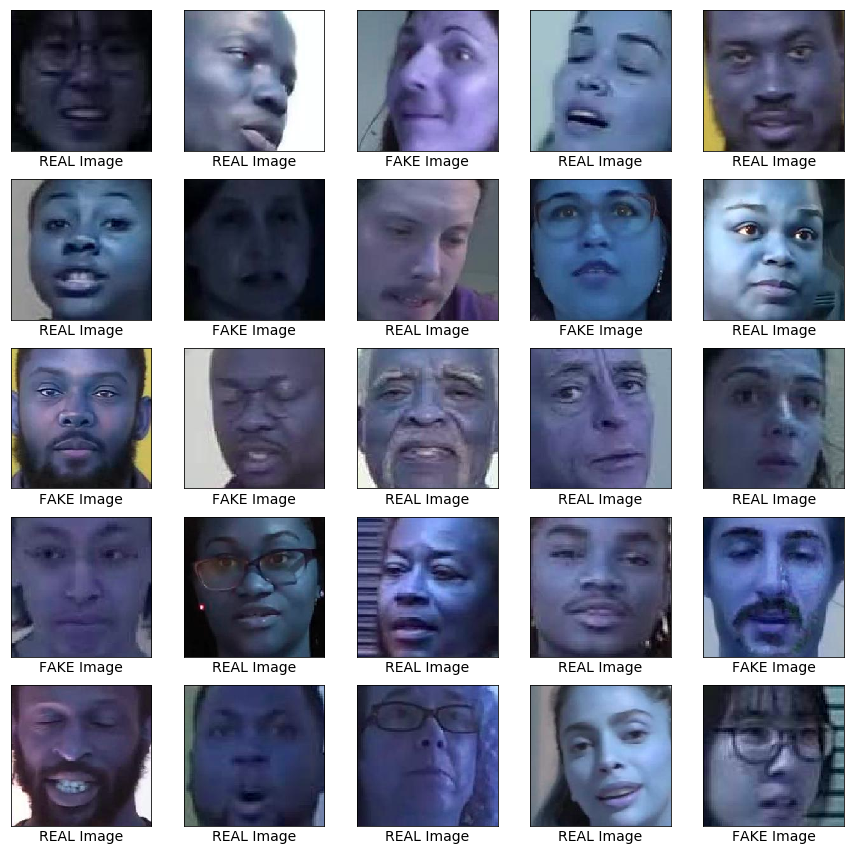

In [14]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

### Custom CNN Architecture

In [15]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [16]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [17]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [18]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [20]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
140/140 [==============================] - 2120s 15s/step - loss: 0.7050 - accuracy: 0.5044 - val_loss: 0.6936 - val_accuracy: 0.4909
Epoch 2/5
140/140 [==============================] - 2085s 15s/step - loss: 0.7195 - accuracy: 0.5002 - val_loss: 0.6934 - val_accuracy: 0.5169
Epoch 3/5
140/140 [==============================] - 2051s 15s/step - loss: 0.7147 - accuracy: 0.5171 - val_loss: 0.6951 - val_accuracy: 0.4943
Epoch 4/5
140/140 [==============================] - 2007s 14s/step - loss: 1.0222 - accuracy: 0.5042 - val_loss: 0.6937 - val_accuracy: 0.5042
Epoch 5/5
140/140 [==============================] - 2093s 15s/step - loss: 0.6944 - accuracy: 0.4996 - val_loss: 0.6933 - val_accuracy: 0.5031


In [21]:
score = model.evaluate(X_test, y_test)

100/100 [==============================] - 178s 2s/step - loss: 0.6930 - accuracy: 0.5150


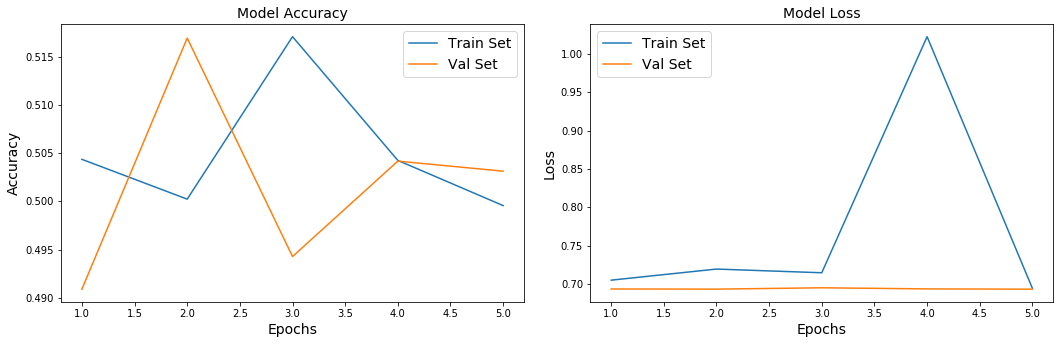

In [22]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

A baseline score of 50.06% is good to go let's finetune some pretrained model

# Pretrained Models for Transfer Learning

Here i used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [23]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [24]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all with values ranging from -1 to 1:

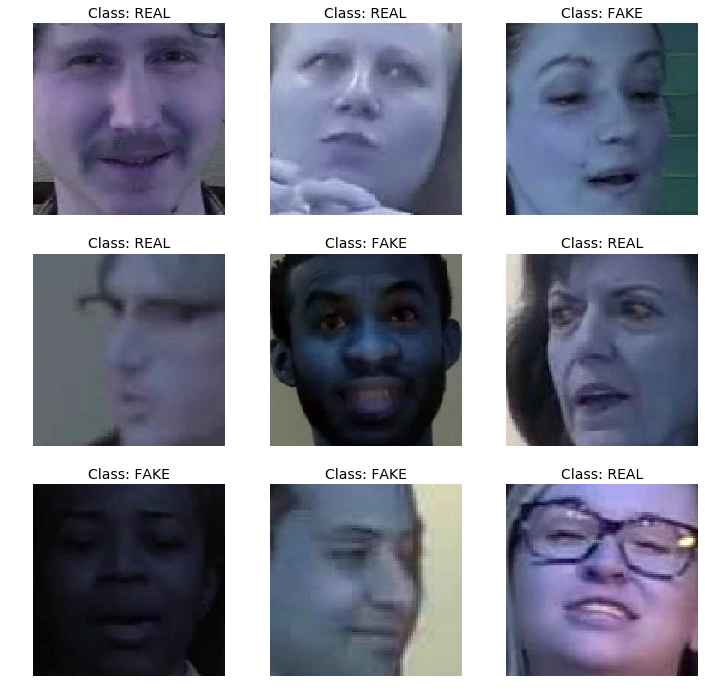

In [25]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

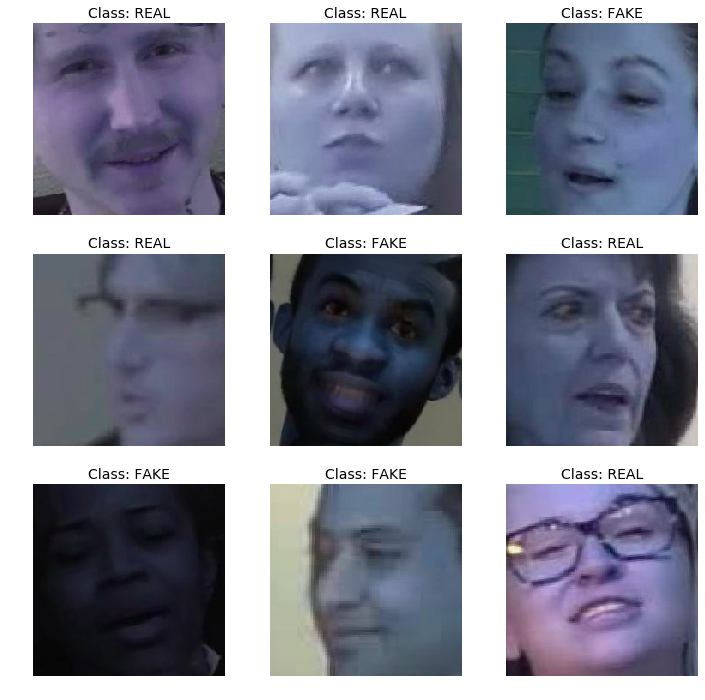

In [27]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own task

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [29]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [30]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 [==============================] - 1071s 4s/step - loss: 1.1115 - accuracy: 0.5724 - val_loss: 0.8563 - val_accuracy: 0.6094
Epoch 2/3
280/280 [==============================] - 1060s 4s/step - loss: 0.9020 - accuracy: 0.6118 - val_loss: 0.9325 - val_accuracy: 0.6104
Epoch 3/3
280/280 [==============================] - 1042s 4s/step - loss: 1.0264 - accuracy: 0.6084 - val_loss: 0.8615 - val_accuracy: 0.6466


In [31]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [32]:
model.evaluate(test_set)

100/100 [==============================] - 265s 3s/step - loss: 0.8431 - accuracy: 0.6384


[0.8431307077407837, 0.6384375095367432]

Now with the finetuning the top layers of xception model the model performance jumps to 63.8% 

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 [==============================] - 2078s 7s/step - loss: 0.6139 - accuracy: 0.6693 - val_loss: 0.5442 - val_accuracy: 0.7273
Epoch 2/10
280/280 [==============================] - 2064s 7s/step - loss: 0.3233 - accuracy: 0.8566 - val_loss: 0.6673 - val_accuracy: 0.7328
Epoch 3/10
280/280 [==============================] - 2060s 7s/step - loss: 0.1729 - accuracy: 0.9334 - val_loss: 0.6426 - val_accuracy: 0.7526
Epoch 4/10
280/280 [==============================] - 2045s 7s/step - loss: 0.1161 - accuracy: 0.9550 - val_loss: 0.9690 - val_accuracy: 0.7669
Epoch 5/10
280/280 [==============================] - 2035s 7s/step - loss: 0.0837 - accuracy: 0.9695 - val_loss: 0.6911 - val_accuracy: 0.7969
Epoch 6/10
280/280 [==============================] - 2026s 7s/step - loss: 0.0548 - accuracy: 0.9796 - val_loss: 1.0601 - val_accuracy: 0.7615
Epoch 7/10
280/280 [==============================] - 2061s 7s/step - loss: 0.0466 - accuracy: 0.9845 - val_loss: 0.7657 - val_accuracy:

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_set)

The model accuracy finally reaches to 81.9%

In [ ]:
model.save('xception_deepfake_image.h5')

# Add Explainability to the model

Lets try to interpret the trained model on how it finds a image FAKE

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [ ]:
plt.figure(figsize=(12, 12))

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow((x[index] + 1) / 2)  # rescale to 0–1 for imshow()
    if(y[index]==1):
        classt='FAKE'
    else:
        classt='REAL'
    plt.title(f"Class: {classt}")
    plt.axis("off")

plt.show()

In [ ]:
test_data=x[2,:,:,:]
test_data.shape

In [ ]:
explanation = explainer.explain_instance(test_data.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

# Conclusion

The deep fake image classifier model gave a generalisation error of around 80%